In [43]:
import enum
from dataclasses import dataclass
import pandas as pd



@dataclass
class Instrument:
    class Type(str, enum.Enum):
        EQUITY = 'EQUITY'
        CRYPTOCURRENCY = 'CRYPTOCURRENCY'

    """Simple structure of an instrument
    """     
    symbol: str
    _type: Type
    prices: pd.DataFrame

In [51]:
from yahoofinancials import YahooFinancials
from datetime import date, timedelta


strf = lambda dt: dt.strftime('%Y-%m-%d')

end_time = date.today()
start_time = end_time - timedelta(days=365)

end = strf(end_time)
start = strf(start_time)

tickers = [ ('NKE','NKE'),  ('XTZ', 'XTZ-USD')]

data = YahooFinancials([ ticker for _,ticker in tickers ]).get_historical_price_data(start, end, 'daily')
  
instruments =  [
    Instrument(
        symbol=f"{symbol}{data.get(ticker,{}).get('currency', '')}",
        _type=Instrument.Type(data.get(ticker,{}).get('instrumentType', None)),
        prices=pd.DataFrame(data.get(ticker,{}).get('prices',[]))[['formatted_date','close']],
    )
    for (symbol,ticker) in tickers
]

prices = instruments[0].prices

In [52]:
import numpy as np

prices['7d_vol'] = prices['close'].rolling(5).std()

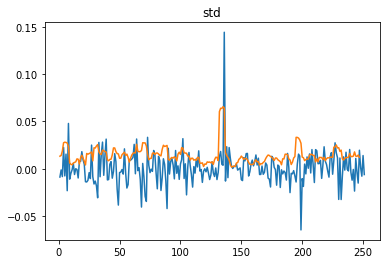

In [53]:
# sort dates in descending order
prices.sort_index(ascending=False, inplace=True)

# calculate daily logarithmic return
prices['returns'] = (np.log(prices.close /
    prices.close.shift(-1)))


prices.returns.plot(title='bar')
prices.returns.rolling(5).std().plot(title='std')

# calculate daily standard deviation of returns
daily_std = np.std(prices.returns)

# annualized daily standard deviation
std = daily_std * 252 ** 0.5

In [33]:
import matplotlib.pyplot as plt
# Plot histograms
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
n, bins, patches = ax.hist(
    prices.returns.values,
    bins=50, alpha=0.65, color='blue')

ax.set_xlabel('log return of stock price')
ax.set_ylabel('frequency of log return')
ax.set_title(f'Historical Volatility for {symbol}')

# get x and y coordinate limits
x_corr = ax.get_xlim()
y_corr = ax.get_ylim()

# make room for text
header = y_corr[1] / 5
y_corr = (y_corr[0], y_corr[1] + header)
ax.set_ylim(y_corr[0], y_corr[1])

# print historical volatility on plot
x = x_corr[0] + (x_corr[1] - x_corr[0]) / 30
y = y_corr[1] - (y_corr[1] - y_corr[0]) / 15
ax.text(x, y , 'Annualized Volatility: ' + str(np.round(std*100, 1))+'%',
    fontsize=11, fontweight='bold')
x = x_corr[0] + (x_corr[1] - x_corr[0]) / 15
y -= (y_corr[1] - y_corr[0]) / 20

# save histogram plot of historical price volatility
#fig.tight_layout()
#fig.savefig('historical volatility.png')
